# Permuted and Split MNIST: a Deep Continual Learning Example in PyTorch

In this brief demo we will showcase two common *Continual Learning* benchmark often used to introduce the problem and start prototyping possible computational strategies to solve it. We will use bare Python, Numpy and *PyTorch*. In order to construct these benchmarks we will start from the the standard MNIST dataset (LeCun, 1998)!

This notebook is part of the **[Continual AI Colab](https://github.com/ContinualAI/colab)**, a repository meant for tutorials and demo running on Google Colaboratory. [Continual AI](https://www.continualai.org/) is an open research community on the topic of Continual Learning and AI! Join us today [on slack](https://continualai.herokuapp.com/)! :-D

This notebook has been also used for the [Continual Learning course](https://course.continualai.org) offered at the *University of Pisa* in conjunction with *ContinualAI* and the *AIDA Doctoral Academy*.

We will start with learning over the standard *MNIST* benchmark, then we will move in the actual continual learning setting  with the *Permuted MNIST* and *Split MNIST*  benchmarks. Let's have some fun! :-)


---
**Connecting a local runtime**

In case resources are not enough for you (no GPU for example), you can always connect another [local runtime](https://research.google.com/colaboratory/local-runtimes.html) or to a [runtime on a Google Compute Engine instance](https://research.google.com/colaboratory/local-runtimes.html).

This notebook has been designed to run fast enough on simple CPUs so you shouldn't find any trouble here, using a free *hosted account*.

---


**Requisites to run it locally, outside colab (not recommended)**

*   Python 3.x
*   Jupyter
*   PyTorch >= 1.8
*   NumPy
*   Matplotlib
---



That's great, let us import then a few libraries, which we'll be using during this tutorial!

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# MNIST: Digits recognition with PyTorch 

All right, let's start then making sure we all know the basics! Let's recognize the ten handwritten digits learning from 60.000, 28x28 grayscale images.
For simplicity let's import a loading script we have already developed inside the **Continual AI Colab** repository:

In [3]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...


In [4]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


100.0%


Extracting data\mnist\MNIST\raw\train-images-idx3-ubyte.gz to data\mnist\MNIST\raw



100.0%


Extracting data\mnist\MNIST\raw\train-labels-idx1-ubyte.gz to data\mnist\MNIST\raw



100.0%


Extracting data\mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to data\mnist\MNIST\raw



100.0%

Extracting data\mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\mnist\MNIST\raw



In [5]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


Let's take a look at the actual images!

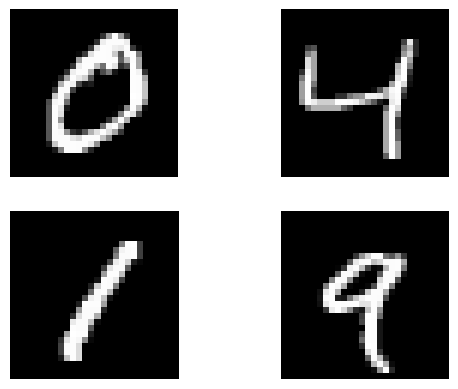

In [6]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Good! Let's now set up a few general setting before using torch...

In [7]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

... and define our first conv-net! We will use 3 layers of convolutions and two fully connected layers:

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

Then we can write the *train* and *test* functions. Note that for simplicity here we are not using PyTorch [Data Loaders](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) but this is not recommended for efficiency.

In [9]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

Then we are ready to instantiate our model and start the training!

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [11]:
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.651316
Test set: Average loss: 0.0013, Accuracy: 9014/10000 (90%)

Train Epoch: 2 	Loss: 0.400198
Test set: Average loss: 0.0007, Accuracy: 9432/10000 (94%)



Wow! 94% accuracy in such a short time. 

**Questions to explore:**

*   Can you find a better parametrization to improve the final accuracy?
*   Can you change the network architecture to improve the final accuracy?
*   Can you achieve the same performances with a smaller architecture?
*   What's the difference in accuracy if you change convolutions with fully connected layers?

Some tips here: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354

# Permuted MNIST

But what if now we want we the same model being able to solve a new task we encounter over time like a permuted version of the same MNIST? Let's define our custom function to permute it!

In [12]:
def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist

In [13]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 0)

starting permutation...
done.


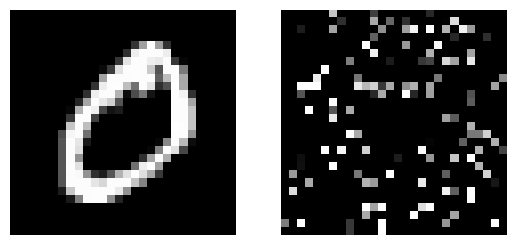

In [14]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[1, 0], cmap="gray")
axarr[1].imshow(x_train2[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Amazing. Now let's see how our pre-trained model is working on both the original and the permuted MNIST dataset:

In [15]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0007, Accuracy: 9432/10000 (94%)

Testing on the second task:
Test set: Average loss: 0.0108, Accuracy: 1081/10000 (11%)



Mmmh... that's pretty bad, our model cannot generalize to this apparently very different new task! Well, we can just finetune our model using the new permuted training set!

In [16]:
for epoch in range(1, 3):
  train(model, device, x_train2, t_train, optimizer, epoch)
  test(model, device, x_test2, t_test)

Train Epoch: 1 	Loss: 1.628576
Test set: Average loss: 0.0033, Accuracy: 7315/10000 (73%)

Train Epoch: 2 	Loss: 1.292066
Test set: Average loss: 0.0022, Accuracy: 8276/10000 (83%)



In [17]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0228, Accuracy: 2387/10000 (24%)

Testing on the second task:
Test set: Average loss: 0.0022, Accuracy: 8276/10000 (83%)



This is very annoying! Now we are not able to solve the original MNIST task anymore! :-( This is the phenomenon known in literature as **Catastrophic Forgetting**! In the following section we well compare three basic baselines for continual learning (and trying to not forget!)

**Questions to explore:**

*   When the permuted MNIST benchmark has been firstly introduced? 
*   Can simple Dropout and Regularization techniques reduce forgetting?
*   In the permuted MNIST task, do convolutions still help increasing the accuracy?

Some tips here: https://papers.nips.cc/paper/5059-compete-to-compute

## Naive Continual Learning by Finetuning

Let us now try to learn continuously with just finetuning and see what we get.
We will build a 3-tasks Permuted MNIST benchmark. Finally we will plot our accuracy results at the end of every task. Let's start by defining our 3 tasks with the function we have already introduced before:



In [18]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task 3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

starting permutation...
done.
starting permutation...
done.


In [19]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [20]:
naive_accs = []

for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task
  
  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc 
  
  naive_accs.append(avg_acc / 3)
  print("Avg acc: ", avg_acc / 3)
  

Training on task:  0
Train Epoch: 1 	Loss: 0.644833
Testing on task:  0
Test set: Average loss: 0.0012, Accuracy: 9034/10000 (90%)

Testing on task:  1
Test set: Average loss: 0.0116, Accuracy: 556/10000 (6%)

Testing on task:  2
Test set: Average loss: 0.0103, Accuracy: 1125/10000 (11%)

Avg acc:  35.71666666666667
Training on task:  1
Train Epoch: 1 	Loss: 1.607625
Testing on task:  0
Test set: Average loss: 0.0228, Accuracy: 1767/10000 (18%)

Testing on task:  1
Test set: Average loss: 0.0044, Accuracy: 6807/10000 (68%)

Testing on task:  2
Test set: Average loss: 0.0119, Accuracy: 1276/10000 (13%)

Avg acc:  32.833333333333336
Training on task:  2
Train Epoch: 1 	Loss: 1.702664
Testing on task:  0
Test set: Average loss: 0.0226, Accuracy: 1500/10000 (15%)

Testing on task:  1
Test set: Average loss: 0.0078, Accuracy: 2913/10000 (29%)

Testing on task:  2
Test set: Average loss: 0.0043, Accuracy: 6873/10000 (69%)

Avg acc:  37.62


**Questions to explore:**

*   Does the order of the tasks effect the final results? 

Some tips here: http://proceedings.mlr.press/v78/lomonaco17a/lomonaco17a.pdf

## Cumulative Strategy

Another simple CL idea is to carry on *all* or *part* of the previously encountered examples (of the previous tasks), shuffling them with the data of the current task. Using *all* the past data is near to the optimal performance we can desire at the end of the task sequence but at the expense of much bigger memory usage.

Let's start by defining a function to shuffle our data:



In [21]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

Now we can reset the model and optimizer and run our training over the tasks sequence:

In [22]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [23]:
cumul_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task
  
  # for previous task
  for i in range(id):
    (past_x_train, past_t_train), _ = tasks[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))
  
  x_train, t_train = shuffle_in_unison([x_train, t_train], 0)
  
  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / 3)
  cumul_accs.append(avg_acc/3)

Training on task:  0
Train Epoch: 1 	Loss: 0.595154
Testing on task:  0
Test set: Average loss: 0.0012, Accuracy: 9063/10000 (91%)

Testing on task:  1
Test set: Average loss: 0.0111, Accuracy: 774/10000 (8%)

Testing on task:  2
Test set: Average loss: 0.0099, Accuracy: 1260/10000 (13%)

Avg acc:  36.989999999999995
Training on task:  1
Train Epoch: 1 	Loss: 0.845960
Testing on task:  0
Test set: Average loss: 0.0008, Accuracy: 9412/10000 (94%)

Testing on task:  1
Test set: Average loss: 0.0037, Accuracy: 7436/10000 (74%)

Testing on task:  2
Test set: Average loss: 0.0101, Accuracy: 1269/10000 (13%)

Avg acc:  60.39000000000001
Training on task:  2
Train Epoch: 1 	Loss: 0.653270
Testing on task:  0
Test set: Average loss: 0.0006, Accuracy: 9499/10000 (95%)

Testing on task:  1
Test set: Average loss: 0.0022, Accuracy: 8359/10000 (84%)

Testing on task:  2
Test set: Average loss: 0.0028, Accuracy: 8030/10000 (80%)

Avg acc:  86.29333333333334


**Questions to explore:**

*   Can you find a way to reduce the number of examples of the previous tasks to maintain in memory? 
*   Can you find a good trade-off between memory overhead and final accuracy?
*   Why is shuffling needed here?

Some tips here: https://arxiv.org/abs/1809.05922

## JointTraining Strategy

While not a proper continual learning strategy, a commonly used baseline for continual learning is what's called "JointTraining" or "offline strategy", that is a multi-task training setting where all the data are seen at once hence simulating a static setting. This is often intended as a performance upper-bound for a continual learning problem.



In [27]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [28]:
offline_accs = []

print("Training on all tasks together...")
avg_acc = 0
(x_train, t_train), _ = tasks[0]
  
for i in range(1, len(tasks)):
    (past_x_train, past_t_train), _ = tasks[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))
  
x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

for epoch in range(1, 4):
    train(model, device, x_train, t_train, optimizer, epoch)
    
for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
print("Avg acc: ", avg_acc / 3)
for i in range(len(tasks)):
    offline_accs.append(avg_acc/3)

Training on all tasks together...
Train Epoch: 1 	Loss: 1.213499
Train Epoch: 2 	Loss: 0.696696
Train Epoch: 3 	Loss: 0.493017
Testing on task:  0
Test set: Average loss: 0.0007, Accuracy: 9463/10000 (95%)

Testing on task:  1
Test set: Average loss: 0.0016, Accuracy: 8831/10000 (88%)

Testing on task:  2
Test set: Average loss: 0.0017, Accuracy: 8796/10000 (88%)

Avg acc:  90.3


**Questions to explore:**

- Is the *JointTraining* strategy really an upper-bound for continual learning?
- Can curriculum learning improve our final performace?

Some tips here: https://arxiv.org/pdf/1904.03626.pdf

## Plot Results

To conclude, let's summerize our results in a nice plot! :-)

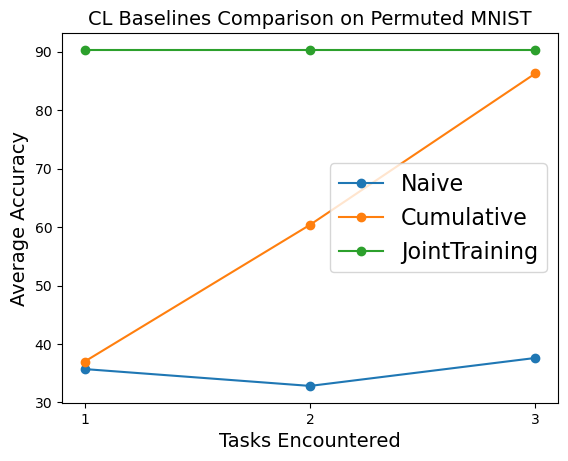

In [29]:
plt.plot([1, 2, 3], naive_accs, '-o', label="Naive")
plt.plot([1, 2, 3], cumul_accs, '-o', label="Cumulative")
plt.plot([1, 2, 3], offline_accs, '-o', label="JointTraining")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Baselines Comparison on Permuted MNIST', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});

**Questions to explore:**

*   What's the difference in terms of memory utilization among the three methods? 
*   Can you plot a similar graph highlighting the memory increase over time?

Some tips here: https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python/30316760

# Split MNIST

Split MNIST is just a split in different batches of the original MNIST data. You can do this definining a simple function such as the following:

In [30]:
def split_mnist(train_x, train_y, test_x, test_y, n_splits=5):
    """ Given the training set, split the tensors by the class label. """
    n_classes = 10
    if n_classes % n_splits != 0:
        print("n_classes should be a multiple of the number of splits!")
        raise NotImplemented
    class_for_split = n_classes // n_splits
    mnist_train_test = [[],[]]  # train and test
    for id, data_set in enumerate([(train_x, train_y), (test_x, test_y)]):
        for i in range(n_splits):
            start = i * class_for_split
            end = (i + 1) * class_for_split
            split_idxs = np.where(np.logical_and(data_set[1] >= start, data_set[1] < end))[0]
            mnist_train_test[id].append((data_set[0][split_idxs], data_set[1][split_idxs]))
    return mnist_train_test

In [31]:
train_x, train_y, test_x, test_y = mnist.load()
splitmnist = split_mnist(train_x, train_y, test_x, test_y, n_splits=5)

In [32]:
for i in range(5):
    train_split_x, train_split_y = splitmnist[0][i]
    test_split_x, tests_split_y = splitmnist[1][i]
    print("train & test splits for task {}: ".format(i))
    print(train_split_x.shape)
    print(train_split_y.shape)
    print(min(train_split_y), max(train_split_y))

train & test splits for task 0: 
(12665, 1, 28, 28)
(12665,)
0 1
train & test splits for task 1: 
(12089, 1, 28, 28)
(12089,)
2 3
train & test splits for task 2: 
(11263, 1, 28, 28)
(11263,)
4 5
train & test splits for task 3: 
(12183, 1, 28, 28)
(12183,)
6 7
train & test splits for task 4: 
(11800, 1, 28, 28)
(11800,)
8 9


**Exercises / Questions to explore**:

- Plot a few sample data belonging to each experience.
- Is **SplitMNIST** harder than **PermutedMNIST**?
- Is it more realistic? Why?
- Compute the results of the introduced baselines. What can you deduce from the plots?

Some tips here: https://arxiv.org/pdf/1904.07734.pdf

**Copyright (c) 2021. Continual AI. All rights reserved.**

See the accompanying LICENSE file in the GitHub repository for terms. 

*Date: 15-11-2021                                                             
Author: Vincenzo Lomonaco                                                    
E-mail: contact@continualai.org                                           
Website: continualai.org*                                               